# HUMAN EMOTION DETECTION
Dataset: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes

[Convolution Visualizer](https://ezyang.github.io/convolution-visualizer/)

# Libraries

In [ ]:
import tensorflow as tf

import numpy as np### math
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint,WandbEvalCallback

# WANDB

In [ ]:
# !pip install --upgrade wandb

In [ ]:
!wandb login

In [ ]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 3,
  "BATCH_SIZE": 32,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 256,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
  "CLASS_NAMES": ["angry", "happy", "sad"],
  "NUM_CLASSES": 3,
}
CONFIGURATION = wandb.config

# Data Downloading from Kaggle

In [ ]:
!pip install -q kaggle

## Make directory

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

## full right to user to read and write

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

## Download the dataset

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

## Unzip into specific folder

In [ ]:
# /content/human-emotions-datasethes.zip

In [ ]:
!unzip /content/human-emotions-datasethes.zip -d /content/dataset

## create tf dataset from the images of this directory

- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [ ]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

In [ ]:
CLASS_NAMES = ["angry", "happy", "sad"] # should be same name as in the directory [/content/dataset/Emotions Dataset/Emotions Dataset/test]

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=42,
    # validation_split=0.2,
    # subset="training",
    # interpolation='bilinear',
    # follow_links=False,
    # crop_to_aspect_ratio=False,
    # pad_to_aspect_ratio=False,
    # data_format=None,
    # verbose=True
)

In [ ]:
train_dataset

In [ ]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=42,
    # validation_split=0.2,
    # subset="training",
    # interpolation='bilinear',
    # follow_links=False,
    # crop_to_aspect_ratio=False,
    # pad_to_aspect_ratio=False,
    # data_format=None,
    # verbose=True
)

In [ ]:
for i in val_dataset.take(1):
  print(i)
  break

# New section

In [ ]:
a = np.array([0,1,0])
print(a)
print(a.argmax())

# Dataset Visualization

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()]) # label_mode = categorical
    # plt.title(CONFIGURATION["CLASS_NAMES"][labels[i].numpy()]) # label_mod = integer
    plt.axis("off")

# Data Preparation

## Data Augmentation

- https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomContrast

In [ ]:
# class RotNinety(Layer):
#   def __init__(self):
#     super().__init__()

#   @tf.function
#   def call(self, image):
#     return tf.image.rot90(image)

In [ ]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025)),
    # RotNinety(), # custome augmentation layer
    RandomContrast(factor = 0.1),
    RandomFlip(mode = "horizontal")
])

In [ ]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

## CUTMIX


In [ ]:
def box(lambd):
  #lambd = tfp.distributions.Beta(0.2, 0.2)
  #lambd = lmbd.sample(1)[0]

  r_x = tf.cast(tfp.distributions.Uniform(low=0.0,high=CONFIGURATION['IM_SIZE']).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(low=0.0,high=CONFIGURATION['IM_SIZE']).sample(1)[0], dtype = tf.int32)



  r_w = tf.cast(CONFIGURATION['IM_SIZE']*tf.math.sqrt(1-lambd), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION['IM_SIZE']*tf.math.sqrt(1-lambd), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION['IM_SIZE']) # clip function  for removing out of the image value
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION['IM_SIZE'])


  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION['IM_SIZE']) # clip function  for removing out of the image value
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION['IM_SIZE'])

  r_w = x_b_r - r_x
  if r_w == 0:
    r_w = 1
  r_h = y_b_r - r_y
  if r_h == 0:
    r_h = 1

  # print(r_x, r_y, r_w, r_h)
  # print(r_y.sample(1)[0])
  return r_y, r_x, r_h, r_w


In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lambd = tfp.distributions.Beta(0.2, 0.2)
  lambd = lambd.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lambd)
  # crop image from image_2
  crop_2 = tf.image.crop_to_bounding_box(
    image_2, r_y, r_x, r_h, r_w
  )
  # make an image from that croped image
  pad_2 = tf.image.pad_to_bounding_box(
    crop_2, offset_height=r_y, offset_width=r_x, target_height=CONFIGURATION['IM_SIZE'], target_width=CONFIGURATION['IM_SIZE']
  )

  # crop the part of this image to remove
  crop_1 = tf.image.crop_to_bounding_box(
      image_1, r_y, r_x, r_h, r_w
  )
  pad_1 = tf.image.pad_to_bounding_box(
      crop_1, offset_height=r_y, offset_width=r_x, target_height=CONFIGURATION['IM_SIZE'], target_width=CONFIGURATION['IM_SIZE']
  )
  image = image_1 - pad_1 + pad_2

  lambd = tf.cast(1 - (r_w * r_h) / (CONFIGURATION['IM_SIZE'] * CONFIGURATION['IM_SIZE']), dtype = tf.float32)
  label = lambd * tf.cast(label_1, dtype = tf.float32) + (1 - lambd) * tf.cast(label_2, dtype = tf.float32)

  return image, label



In [ ]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

## TFRECORDS - More Efficient Data Pipeline

 https://www.tensorflow.org/tutorials/load_data/tfrecord

### Unbatching

In [ ]:
training_dataset = (
    train_dataset
    #.map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .unbatch()
)

In [ ]:
validation_dataset = (
    val_dataset
    .unbatch()
)

In [ ]:
print(training_dataset)
print(validation_dataset)

- https://www.tensorflow.org/api_docs/python/tf/train/Feature

In [ ]:
# ERROR_1: AttributeError: 'numpy.float32' object has no attribute '__index__'

# The above exception was the direct cause of the following exception:

# SystemError                               Traceback (most recent call last)
# 2 frames
# /usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/tensor.py in __next__(self)
#     128   def __next__(self):
#     129     if self._index == self._limit:
# --> 130       raise StopIteration
#     131     result = self._tensor[self._index]
#     132     self._index += 1

# SystemError: <class 'StopIteration'> returned a result with an exception set



def create_example(image, label):

  #label_index = tf.argmax(label, axis = -1)
  # int64_list=Int64List(value = [tf.argmax(label, axis = -1).numpy()]))
  # label - int features
  label_scaler = tf.squeeze(label)
  int_feature = Feature(
      int64_list=Int64List(value = [int(label_scaler.numpy())]))# Solution : ERROR_1 []

  # image features - image
  bytes_feature = tf.train.Feature(
      bytes_list=BytesList(value = [image])) #Solution : ERROR_1 []

  example = Example(
      features=Features(feature={
          'image': bytes_feature,
          'label': int_feature,
      }))
  return example.SerializeToString()

In [ ]:
# ERROR_2

# TypeError                                 Traceback (most recent call last)
# /tmp/ipython-input-123-2591357298.py in <cell line: 0>()
#       9   with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
#      10     for image, label in shard_dataset:
# ---> 11         file_writer.write(create_example(image, label))

# 1 frames
# /usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py in __index__(self)
#     316
#     317   def __index__(self) -> int:
# --> 318     return cast(np.ndarray, self._numpy()).__index__()
#     319
#     320   def __bool__(self) -> bool:

# TypeError: only integer scalar arrays can be converted to a scalar index
#########SOLUTION
# int_feature = Feature(
#       int64_list=Int64List(value = [label.numpy()]))
##########

# ERROR_3 ---------------------------------------------------------------------------
# TypeError                                 Traceback (most recent call last)
# /tmp/ipython-input-131-2591357298.py in <cell line: 0>()
#       9   with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
#      10     for image, label in shard_dataset:
# ---> 11         file_writer.write(create_example(image, label))

# /tmp/ipython-input-130-1047734668.py in create_example(image, label)
#      22   # label - int features
#      23   int_feature = Feature(
# ---> 24       int64_list=Int64List(value = [label.numpy()]))# Solution : ERROR_1 []
#      25
#      26   # image features - image

# TypeError: only integer scalar arrays can be converted to a scalar index
#############SOLUTION
# int_feature = Feature(
#       int64_list=Int64List(value = [tf.argmax(label, axis = -1).numpy()]))
#############



# ERROR_4 ---------------------------------------------------------------------------
# TypeError                                 Traceback (most recent call last)
# /tmp/ipython-input-129-2591357298.py in <cell line: 0>()
#       9   with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
#      10     for image, label in shard_dataset:
# ---> 11         file_writer.write(create_example(image, label))

# /tmp/ipython-input-127-927428001.py in create_example(image, label)
#      26   # image features - image
#      27   bytes_feature = tf.train.Feature(
# ---> 28       bytes_list=BytesList(value = [image])) #Solution : ERROR_1 []
#      29
#      30   example = Example(

# TypeError: expected bytes, tensorflow.python.framework.ops.EagerTensor found
########SOLUTION

########




- TypeError: expected bytes, tensorflow.python.framework.ops.EagerTensor found
- SOLUTION :
- https://www.tensorflow.org/api_docs/python/tf/io/decode_image
- https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)


In [ ]:
training_dataset

In [ ]:
train_dataset

In [ ]:
encoded_dataset = (
  training_dataset
  .map(encode_image)
)

In [ ]:
encoded_dataset

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

- 1. how to write in tfrecord file : https://www.tensorflow.org/api_docs/python/tf/io/TFRecordWriter

- 2. Dataset Shard - https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shard

In [ ]:
# Write the records to a file.
for shard_number in range(NUM_SHARDS):
  # 2
  shard_dataset =  (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )
  # 1
  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for image, label in shard_dataset:
        file_writer.write(create_example(image, label))

### Parse the tfrecorder into tf dataset (save in some where for permenent)

In [ ]:
recorded_dataset = tf.data.TFRecordDataset(filenames = [PATH.format(p) for p in range(NUM_SHARDS)])

In [ ]:
l = [PATH.format(p) for p in range(NUM_SHARDS)]
print(l)

In [ ]:
def parse_tfrecords(example):

    # dictionary of features
    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }
    # parse the dictionary
    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
                  tf.io.decode_jpeg(
                      example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]

In [ ]:
parsed_dataset = (
    recorded_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
print(parsed_dataset)

In [ ]:
# len(parsed_dataset)

In [ ]:
# for i in parsed_dataset.take(1):
#   print(i)

### Data Augmentation continue

In [ ]:
# more efficient uses of the data, already included bacth
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

# after including cutmix
# training_dataset = (
#     mixed_dataset
#     .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE
# )

In [ ]:

val_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
print(training_dataset)
print(val_dataset)

# Resize and Rescale Layers

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
  Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
  Rescaling(1./255),
])

# Model

In [ ]:

IMG_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']
POOL_SIZE = CONFIGURATION['POOL_SIZE']

model = tf.keras.Sequential([
  InputLayer(shape= (None,None, 3)), # input could be any dimension.

  resize_rescale_layers,
  Conv2D(filters = N_FILTERS, kernel_size = KERNEL_SIZE, strides = N_STRIDES, activation = 'relu', padding = 'same', kernel_regularizer=L2(REGULARIZATION_RATE)),
  BatchNormalization(),
  MaxPool2D(pool_size = POOL_SIZE, strides = N_STRIDES),
  Dropout(DROPOUT_RATE), #

  Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides = N_STRIDES, activation = 'relu', padding = 'same', kernel_regularizer=L2(REGULARIZATION_RATE)),
  BatchNormalization(),
  MaxPool2D(pool_size = POOL_SIZE, strides = N_STRIDES),

  Flatten(),

  Dense(CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer=L2(REGULARIZATION_RATE)),
  BatchNormalization(),
  Dropout(DROPOUT_RATE),
  Dense(CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer=L2(REGULARIZATION_RATE)),
  BatchNormalization(),
  Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),# 3 catagories



])

model.summary()

# Training

## Loss Function

In [ ]:
loss_function = CategoricalCrossentropy()

In [ ]:
# if label_mode = categorical
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.05, 0.85]]
# Using 'auto'/'sum_over_batch_size' reduction type.
cce = tf.keras.losses.CategoricalCrossentropy()
cce(y_true, y_pred)
# this value tells us, how close the prediction of the model to the true y
# high value -- high chance of false prediction
# low value (close to 0) - high chance of true prediction

In [ ]:
# if label_mode = int
y_true = tf.constant([1,2])
y_pred = tf.constant([[0.05, 0.95, 0], [0.1, 0.05, 0.85]])
# Using 'auto'/'sum_over_batch_size' reduction type.
cce = tf.keras.losses.SparseCategoricalCrossentropy()
cce(y_true, y_pred)

## metrics

In [ ]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k = 2, name = "top_2_accuracy")]


## compile

In [ ]:
model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

## fit

In [ ]:
training_dataset

In [ ]:
history = model.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = 20, #CONFIGURATION['N_EPOCHS'],
    verbose = 1
)

# PLOT

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'])
  plt.show()

In [ ]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train_accuracy', 'val_accuracy'])
  plt.show()

# Evaluate the model performance on validation data

In [ ]:
model.evaluate(val_dataset)

# Test the model

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109046.jpg_brightness_1.jpg")

im = tf.constant(test_image, dtype=tf.float32)

im = tf.expand_dims(im, axis = 0) # add batch

# [angry, happy, sad]

In [ ]:
print(CONFIGURATION["CLASS_NAMES"][tf.argmax(model(im), axis = -1).numpy()[0]])

In [ ]:
test_image_1 = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/10416.jpg_rotation_2.jpg")

im_2 = tf.constant(test_image_1, dtype=tf.float32)

im_2 = tf.expand_dims(im_2, axis = 0) # add batch

# [angry, happy, sad]

print(CONFIGURATION["CLASS_NAMES"][tf.argmax(model(im_2), axis = -1).numpy()[0]])

In [ ]:
def test_model(model, val_dataset):
  plt.figure(figsize = (12,12))

  for images, labels in val_dataset.take(1):
    for i in range(16):
      ax = plt.subplot(4,4, i+1)
      plt.imshow(images[i]/255.)
      plt.title("True Label: "+ CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()] + "\n" + "Predicted Label: " + CONFIGURATION["CLASS_NAMES"][tf.argmax(model(tf.expand_dims(images[i], axis = 0)), axis = -1).numpy()[0]]) # label_mode = categorical
      # plt.title(CONFIGURATION["CLASS_NAMES"][labels[i].numpy()]) # label_mod = integer
      plt.axis("off")

In [ ]:
12/16

# CONFUSION MATRIX

In [ ]:
#def confusion_matrix(val_dataset, model):
predicted = []
labels = []

for im, label in val_dataset:
  predicted.append(model(im))
  labels.append(label.numpy())

  # batch mismatch in last batch so concat last batch with previous all batches
pred = np.concatenate((np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()))
labels = np.concatenate((np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()))

cm = confusion_matrix(labels, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
# print(predicted)
# without last batch (error - last batch may be less than 32)
print(np.argmax(labels[:-1], axis = -1).flatten())
print(np.argmax(predicted[:-1], axis = -1).flatten())

# concatination last batch with previous all batches
print(np.concatenate((np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten())))
print(np.concatenate((np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten())))

In [ ]:
pred = np.concatenate((np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()))
labels = np.concatenate((np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()))


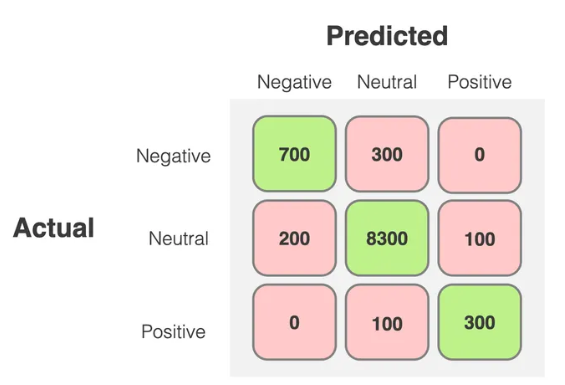

In [ ]:
cm = confusion_matrix(labels, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')



- Pooling layers: Down sample the informations from the input. Such that we go deeper into the neural network, we reduce the number of features.

# RESNET 34

- positional argument
- keyword argument

[ResNets](https://arxiv.org/pdf/1512.03385)

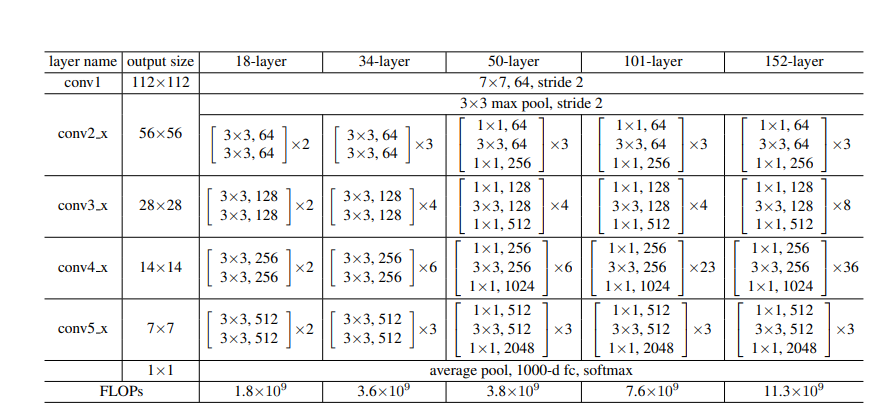

## CustomConv2D

- https://www.tensorflow.org/tutorials/customization/custom_layers

In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training=training)

    return x

## Residual Block

- https://www.tensorflow.org/api_docs/python/tfm/vision/layers/ResidualBlock?hl=en#methods

In [ ]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    # padding - height and width features of an image doesn't change
    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training=training)
    x = self.custom_conv_2(x, training=training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training=training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

## ResNet34 Architructute from paper

- model subclassing

In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2) # stride 2 - downsampling
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2) # down sampling
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training=training)
    x = self.conv_2_2(x, training=training)
    x = self.conv_2_3(x, training=training)

    x = self.conv_3_1(x, training=training)
    x = self.conv_3_2(x, training=training)
    x = self.conv_3_3(x, training=training)
    x = self.conv_3_4(x, training=training)

    x = self.conv_4_1(x, training=training)
    x = self.conv_4_2(x, training=training)
    x = self.conv_4_3(x, training=training)
    x = self.conv_4_4(x, training=training)
    x = self.conv_4_5(x, training=training)
    x = self.conv_4_6(x, training=training)

    x = self.conv_5_1(x, training=training)
    x = self.conv_5_2(x, training=training)
    x = self.conv_5_3(x, training=training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [ ]:
resnet = ResNet34()
resnet(tf.zeros([1, 256, 256, 3]), training = False)
resnet.summary()

[ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    # save_weights_only=False,
    # mode='auto',
    # save_freq='epoch',
    #initial_value_threshold=None
)

# checkpoint_callback = ModelCheckpoint(
#     'best_weights',
#     monitor='val_accuracy',
#     mode = 'max',
#     verbose=1,
#     save_best_only=True,

#     )

## Loss Function

In [ ]:
loss_function = CategoricalCrossentropy()

## Metrics

In [ ]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k = 2, name="top_k_accuracy")]

## Model Compile

In [ ]:
resnet.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']*10),
    loss = loss_function,
    metrics = metrics
)

## Fit

In [ ]:
history = resnet.fit(
                    training_dataset,
                     validation_data = val_dataset,
                     epochs = 20*3,
                     callbacks = [checkpoint_callback]
                     )

## Plot

In [ ]:
plot_accuracy(history)

In [ ]:
plot_loss(history)

## Evaluate the model

In [ ]:
resnet.evaluate(val_dataset)

In [ ]:
test_model(resnet, val_dataset)

- Test My Image


In [ ]:
# def test_model(model, val_dataset):
#   plt.figure(figsize = (12,12))

#   for images, labels in val_dataset.take(1):
#     for i in range(16):
#       ax = plt.subplot(4,4, i+1)
#       plt.imshow(images[i]/255.)
#       plt.title("True Label: "+ CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()] + "\n" + "Predicted Label: " + CONFIGURATION["CLASS_NAMES"][tf.argmax(model(tf.expand_dims(images[i], axis = 0)), axis = -1).numpy()[0]]) # label_mode = categorical
#       # plt.title(CONFIGURATION["CLASS_NAMES"][labels[i].numpy()]) # label_mod = integer
#       plt.axis("off")

In [ ]:
test_image_1 = cv2.imread("/content/dataset/happy.jpeg")
test_image_2 = cv2.imread("/content/dataset/sad.jpeg")
test_image_3 = cv2.imread("/content/dataset/angry.jpeg")

im_1 = tf.constant(test_image_1, dtype=tf.float32)
im_1 = tf.expand_dims(im_1, axis = 0)

im_2 = tf.constant(test_image_2, dtype=tf.float32)
im_2 = tf.expand_dims(im_2, axis = 0) # add batch

im_3 = tf.constant(test_image_3, dtype=tf.float32)
im_3 = tf.expand_dims(im_3, axis = 0)

# dataset = tf.constant([im_1, im_2, im_3])

# [angry, happy, sad]

# print(CONFIGURATION["CLASS_NAMES"][tf.argmax(resnet(im_2), axis = -1).numpy()[0]])

In [ ]:
image_paths = [
    ("/content/dataset/happy.jpeg", "Happy"),
    ("/content/dataset/sad.jpeg", "Sad"),
    ("/content/dataset/angry.jpeg", "Angry")
]
plt.figure(figsize=(12, 4))

for idx, (img_path, label) in enumerate(image_paths):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    img_tensor = tf.constant(img_rgb, dtype=tf.float32)
    img_tensor = tf.image.resize(img_tensor, (256, 256))  # Resize if needed
    img_tensor = tf.expand_dims(img_tensor, axis=0)

    pred = tf.argmax(resnet(img_tensor), axis=-1).numpy()[0]
    pred_label = CONFIGURATION["CLASS_NAMES"][pred]

    # Plot
    plt.subplot(1, 3, idx + 1)
    plt.imshow(img_rgb / 255.)
    plt.axis('off')
    plt.title(f"Predicted: {pred_label}")

plt.tight_layout()
plt.show()

In [ ]:
# im_2

In [ ]:
#def confusion_matrix(val_dataset, model):
predicted = []
labels = []

for im, label in val_dataset:
  predicted.append(resnet(im))
  labels.append(label.numpy())



In [ ]:
print(labels)

In [ ]:
# ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (72,) + inhomogeneous part. [BATCH MISMATCH]
predicted_1 = np.argmax(predicted[:-1], axis = -1).flatten()
labels_1 = np.argmax(labels[:-1], axis = -1).flatten()
predicted_2 = np.argmax(predicted[-1], axis = -1).flatten()
labels_2 = np.argmax(labels[-1], axis = -1).flatten()

concat_pred = np.concatenate((predicted_1, predicted_2))
concat_labels = np.concatenate((labels_1, labels_2))

In [ ]:
print(predicted_1.shape)
print(labels_1.shape)
print(predicted_2.shape)
print(labels_2.shape)

print(type(concat_pred))
print(type(concat_labels))

In [ ]:
# batch mismatch in last batch so concat last batch with previous all batches
# pred = np.concatenate((np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()))
# labels = np.concatenate((np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()))

# print(pred)
# print(labels)

In [ ]:
cm = confusion_matrix(concat_labels, concat_pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# MobileNet